In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
data_path='/home/uj-user/Yo/hybrid-ltm/data_eval/context-fms/MS_DG/test.jsonl'
df = pd.read_json(data_path, lines=True, orient='records')
df['len'] = df['input'].apply(len)
df

,input,output,eval_indicator,len
0,"```\nDialogue Session #1:\nPatient: Hi, doctor...","Doctor:Ah yes, jet lag can be tough. It's impo...",Engagingness,3640
1,"```\nDialogue Session #1:\nNeighbors A:Hi, Nei...","Neighbors A:Well, I have some experience with ...",Specificity,2415
2,```\nDialogue Session #1:\nCo-workers A:I have...,Co-workers B:That's a good perspective to have...,Memorability,3624
3,"```\nDialogue Session #1:\nMentee:Mentor, I we...","Mentee:Exactly, Mentor. I remember a time in m...",Specificity,1513
4,"```\nDialogue Session #1:\nClassmates A:Hey, g...","Classmates B:Yes, I'll never forget that. It w...",Humanness,5787
...,...,...,...,...
75,```\nDialogue Session #1:\nHusband:You always ...,"Wife:Sure, we can do that. You know, speaking ...",Engagingness,3949
76,"```\nDialogue Session #1:\nClassmates A:Hey, B...","Classmates A:Thanks, I just did what I had to ...",Memorability,3980
77,"```\nDialogue Session #1:\nClassmates A:Hey, B...",Classmates A:I like the idea of serving my cou...,Specificity,2735
78,```\nDialogue Session #1:\nHusband:I really do...,Husband:It might be worth getting a second opi...,Specificity,2464


In [11]:
df['len'].groupby(df['eval_indicator']).mean()

eval_indicator
Engagingness    3695.40
Humanness       4141.15
Memorability    4233.15
Specificity     3843.60
Name: len, dtype: float64

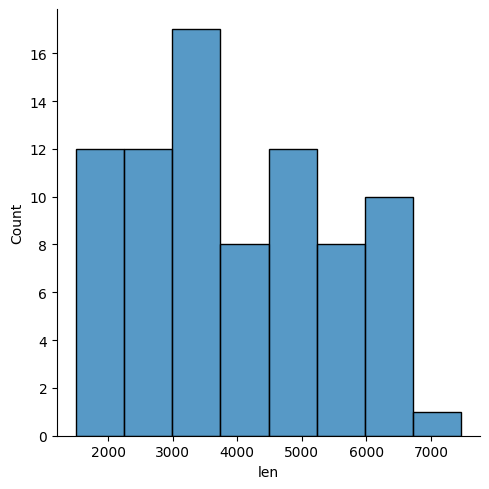

In [12]:
sns.displot(df['len'])

In [13]:
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
data = Dataset.from_pandas(df)
ds = DatasetDict({'train':data})
print(ds)
tokenizer = AutoTokenizer.from_pretrained('pinkmanlove/llama-7b-hf', use_fast=False)

def tokenize_func(example):
    return tokenizer(example['input'], max_length=4096, truncation=True)
# encoded = tokenizer.encode(output_df['input'][0])
# len(encoded)
prep_datda = data.map(tokenize_func, num_proc=96)
print(prep_datda)

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'eval_indicator', 'len'],
        num_rows: 80
    })
})


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
num_proc must be <= 80. Reducing num_proc to 80 for dataset of size 80.
Map (num_proc=80): 100%|██████████| 80/80 [00:00<00:00, 187.50 examples/s]


Dataset({
    features: ['input', 'output', 'eval_indicator', 'len', 'input_ids', 'attention_mask'],
    num_rows: 80
})


/home/uj-user/Yo/hybrid-ltm/ltm-venv/lib/python3.8/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/home/uj-user/Yo/hybrid-ltm/ltm-venv/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [14]:
df= pd.DataFrame(prep_datda)
df['token_len'] = df['input_ids'].apply(len)
df['token_len'].max()

2134

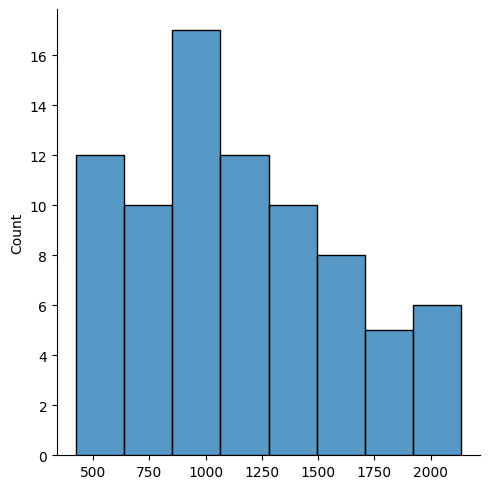

In [15]:
import seaborn as sns
data_len = [len(p) for p in prep_datda['input_ids']]
sns.displot(data_len)

In [16]:
Humaness = [ 70, 476, 456, 439, 403, 383, 377, 376, 374, 366, 358, 327, 123, 134, 149, 198, 248, 249, 258, 293]
Engageness =  [ 97, 477, 482, 444, 420, 372, 367, 317, 4, 122, 137, 148, 161, 180, 185, 189, 190, 209, 266, 287]
Memorability = [ 88, 73, 56, 90, 76, 489, 448, 395, 392, 389, 368, 350, 195, 299, 262, 282, 113, 160, 243, 617]
Specificity=[ 436, 356, 355, 333, 332, 94, 64, 567, 40, 133, 144, 177, 182, 194, 224, 234, 270, 276, 285, 547]

In [17]:
cc = load_dataset('jihyoung/ConversationChronicles')
df = cc['test'].to_pandas()

/home/uj-user/Yo/hybrid-ltm/ltm-venv/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [18]:
df_test = df.sample(frac=0.05, random_state=2023).reset_index()
df_test['eval_indicator'] = None
df_test.loc[Humaness, 'eval_indicator'] = 'Humanness'
df_test.loc[Engageness, 'eval_indicator'] = 'Engagingness'
df_test.loc[Memorability, 'eval_indicator'] = 'Memorability'
df_test.loc[Specificity, 'eval_indicator'] = 'Specificity'
df_test.dropna()

,index,dataID,relationship,time_interval,summary,first_session_dialogue,first_session_speakers,second_session_dialogue,second_session_speakers,third_session_dialogue,third_session_speakers,fourth_session_dialogue,fourth_session_speakers,fifth_session_dialogue,fifth_session_speakers,eval_indicator
4,3789,episode-161650,Patient and Doctor,"[Start, A couple of years after, A couple of y...",[The patient asks the doctor about the procedu...,"[ Hi, doctor. I'm all set for the surgery. Jus...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, that was amazing! How did you learn t...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Hello Patient, how can I assist you today?, H...","[Doctor, Patient, Doctor, Patient, Doctor, Pat...","[Doctor, I have to tell you about something th...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[ Doctor, I'm feeling really jealous of my bro...","[Patient, Doctor, Patient, Doctor, Patient, Do...",Engagingness
40,18286,episode-215797,Neighbors,"[Start, A couple of years after, A few days af...",[Neighbors A apologizes for Neighbors B's nerv...,"[Hi, Neighbors B. How are you doing?, I'm doin...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Hey, have you noticed that I'm limping lately...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Hey there, have you ever considered pursuing ...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Wow, your place was really a mess when I came...","[Neighbors A, Neighbors B, Neighbors A, Neighb...",[ I'm really sorry for what I did. I don't kno...,"[Neighbors A, Neighbors B, Neighbors A, Neighb...",Specificity
56,13873,episode-81965,Co-workers,"[Start, A couple of years after, A couple of y...",[Co-worker A noticed Co-worker B gained influe...,[I have noticed that you have gained a lot of ...,"[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, have you seen the new movie that just ca...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey there,. You look stunning today., Thanks,...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, B, I wanted to apologize again for askin...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, have you heard? I'm single now., Oh, rea...","[Co-workers A, Co-workers B, Co-workers A, Co-...",Memorability
64,14302,episode-87771,Mentee and Mentor,"[Start, A few weeks after, A few days after, A...",[The Mentee fetches water from the well to sav...,"[Mentor, I went to the well today to fetch wat...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, I had a conversation with personY tod...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mentor]",[I can't believe I have to clean up this mess....,"[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, I just want to thank you for always b...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, do you remember when I used to be so ...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...",Specificity
70,17810,episode-210219,Classmates,"[Start, A few days after, A few hours after, A...",[Classmate A helped a friend with math homewor...,"[Hey, guess what? I helped a new friend with t...","[Classmates A, Classmates B, Classmates A, Cla...","[Hey, you seem really down. Is everything okay...","[Classmates A, Classmates B, Classmates A, Cla...","[I need to tell you something, I've been feeli...","[Classmates A, Classmates B, Classmates A, Cla...","[, guess what happened when I went to the park...","[Classmates A, Classmates B, Classmates A, Cla...",[Sorry to cover my face while taking your phot...,"[Classmates A, Classmates B, Classmates A, Cla...",Humanness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,15343,episode-102620,Husband and Wife,"[Start, A couple of years after, A few weeks a...",[The husband expresses gratitude towards his w...,"[You always brighten up my day, honey!, Aww, t...","[Husband, Wife, Husband, Wife, Husband, Wife, ...",[Have you ever noticed how mesmerizing f

tasks/MS_DG/test.jsonl


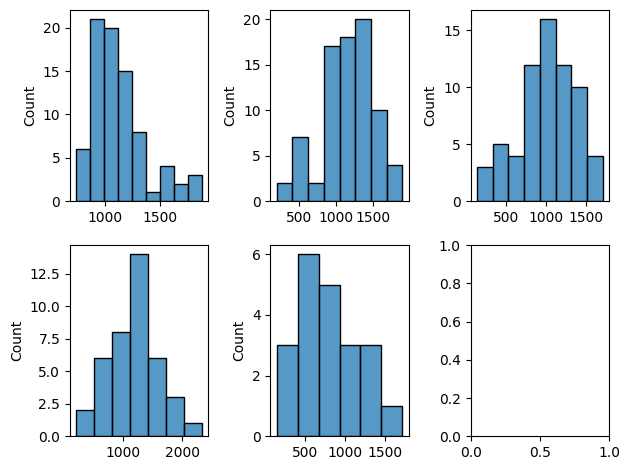

80


In [19]:
dataset_path = glob('tasks/MS_DG')
save_path = './context-fms-train'
os.makedirs(save_path, exist_ok=True)

for path in dataset_path:
    file_path = path + '/test.jsonl'
    dataset_name = path.split('/')[-1]
    print(file_path)
    df = pd.read_json(file_path, lines=True, orient='records')
    
    output = df['input'][df_test.dropna().index]
    output_df = pd.DataFrame(output)
    output_df['input'] = output_df['input'].map(lambda x: '```'+ '```'.join(x.split('```')[1:-3]) +'```')
    output_df['output'] = df['output'][df_test.dropna().index]
    output_df['eval_indicator'] = df_test.dropna()['eval_indicator']
    # print(output_df)
    # os.makedirs(f'{save_path}/{dataset_name}',exist_ok=True)
    # output_df.to_json(f'{save_path}/{dataset_name}/test.jsonl', lines=True, orient='records')
    
data_session = output_df['input'].map(lambda x: x.replace('```','').replace('\n',' ').split('Dialogue Session #')).reset_index(drop=True)
data_session = [session[1:] for session in data_session]
len_session = [len(session) for session in data_session]
session1_len = [len(session[0]) for session in data_session]
session2_len = [len(session[1]) for session in data_session if len(session)>1]
session3_len = [len(session[2]) for session in data_session  if len(session)>2]
session4_len = [len(session[3]) for session in data_session  if len(session)>3]
session5_len = [len(session[4]) for session in data_session  if len(session)>4]

# sns.displot(len_session)
cols = [session1_len, session2_len, session3_len, session4_len, session5_len]
fig, axes = plt.subplots(2,3)
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(data=col, ax=ax)
fig.tight_layout()
plt.show()
print(len(session2_len))

In [20]:
eval_fms = df_test.dropna()
eval_fms['relationship'].value_counts()

relationship
Classmates             24
Neighbors              21
Husband and Wife        8
Mentee and Mentor       7
Patient and Doctor      6
Co-workers              6
Parent and Child        4
Athlete and Coach       2
Student and Teacher     2
Name: count, dtype: int64

In [21]:
data = eval_fms.groupby(['eval_indicator', 'relationship', ])['index'].size().unstack(fill_value=0)
data

relationship,Athlete and Coach,Classmates,Co-workers,Husband and Wife,Mentee and Mentor,Neighbors,Parent and Child,Patient and Doctor,Student and Teacher
eval_indicator,,,,,,,,,
Engagingness,1,4,3,2,1,5,1,3,0
Humanness,0,9,0,3,1,5,1,1,0
Memorability,0,7,1,1,0,8,1,1,1
Specificity,1,4,2,2,5,3,1,1,1


<Axes: xlabel='relationship', ylabel='eval_indicator'>

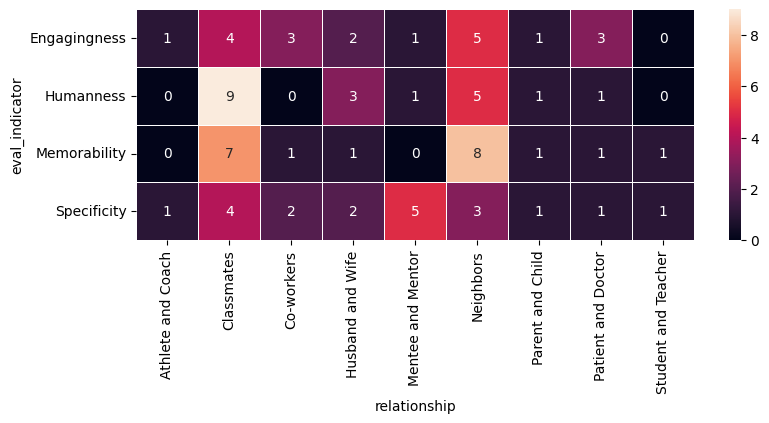

In [22]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(9, 3))
sns.heatmap(data, annot=True, fmt="d", linewidths=.5, ax = ax)

In [23]:
eval_fms

,index,dataID,relationship,time_interval,summary,first_session_dialogue,first_session_speakers,second_session_dialogue,second_session_speakers,third_session_dialogue,third_session_speakers,fourth_session_dialogue,fourth_session_speakers,fifth_session_dialogue,fifth_session_speakers,eval_indicator
4,3789,episode-161650,Patient and Doctor,"[Start, A couple of years after, A couple of y...",[The patient asks the doctor about the procedu...,"[ Hi, doctor. I'm all set for the surgery. Jus...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, that was amazing! How did you learn t...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Hello Patient, how can I assist you today?, H...","[Doctor, Patient, Doctor, Patient, Doctor, Pat...","[Doctor, I have to tell you about something th...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[ Doctor, I'm feeling really jealous of my bro...","[Patient, Doctor, Patient, Doctor, Patient, Do...",Engagingness
40,18286,episode-215797,Neighbors,"[Start, A couple of years after, A few days af...",[Neighbors A apologizes for Neighbors B's nerv...,"[Hi, Neighbors B. How are you doing?, I'm doin...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Hey, have you noticed that I'm limping lately...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Hey there, have you ever considered pursuing ...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Wow, your place was really a mess when I came...","[Neighbors A, Neighbors B, Neighbors A, Neighb...",[ I'm really sorry for what I did. I don't kno...,"[Neighbors A, Neighbors B, Neighbors A, Neighb...",Specificity
56,13873,episode-81965,Co-workers,"[Start, A couple of years after, A couple of y...",[Co-worker A noticed Co-worker B gained influe...,[I have noticed that you have gained a lot of ...,"[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, have you seen the new movie that just ca...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey there,. You look stunning today., Thanks,...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, B, I wanted to apologize again for askin...","[Co-workers A, Co-workers B, Co-workers A, Co-...","[Hey, have you heard? I'm single now., Oh, rea...","[Co-workers A, Co-workers B, Co-workers A, Co-...",Memorability
64,14302,episode-87771,Mentee and Mentor,"[Start, A few weeks after, A few days after, A...",[The Mentee fetches water from the well to sav...,"[Mentor, I went to the well today to fetch wat...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, I had a conversation with personY tod...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mentor]",[I can't believe I have to clean up this mess....,"[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, I just want to thank you for always b...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...","[Mentor, do you remember when I used to be so ...","[Mentee, Mentor, Mentee, Mentor, Mentee, Mento...",Specificity
70,17810,episode-210219,Classmates,"[Start, A few days after, A few hours after, A...",[Classmate A helped a friend with math homewor...,"[Hey, guess what? I helped a new friend with t...","[Classmates A, Classmates B, Classmates A, Cla...","[Hey, you seem really down. Is everything okay...","[Classmates A, Classmates B, Classmates A, Cla...","[I need to tell you something, I've been feeli...","[Classmates A, Classmates B, Classmates A, Cla...","[, guess what happened when I went to the park...","[Classmates A, Classmates B, Classmates A, Cla...",[Sorry to cover my face while taking your phot...,"[Classmates A, Classmates B, Classmates A, Cla...",Humanness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,15343,episode-102620,Husband and Wife,"[Start, A couple of years after, A few weeks a...",[The husband expresses gratitude towards his w...,"[You always brighten up my day, honey!, Aww, t...","[Husband, Wife, Husband, Wife, Husband, Wife, ...",[Have you ever noticed how mesmerizing f

In [24]:
df_list =[]
for key in eval_fms['eval_indicator'].value_counts().keys():
	print(key)
	# print(eval_fms[eval_fms['eval_indicator']==key])
	df_list.append(eval_fms[eval_fms['eval_indicator']==key].reset_index(drop=True))

Engagingness
Specificity
Memorability
Humanness


In [25]:
import torch
from transformers import AutoModel, AutoTokenizer
# model_name = 'microsoft/deberta-large-mnli'
model_name = 'allenai/longformer-large-4096'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device='cuda:1'
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [26]:

def make_embedding(df_list, tokenizer, model, device):
	np_emb_all_list = []
	for df in df_list:
		emb_all = []
		for sent in tqdm(df['summary']):
			max_sequence_length = 512
			# print(sent)
			token = tokenizer(sent.tolist(), padding="max_length", truncation=True, max_length=max_sequence_length, return_tensors="pt")
			# print(token)
			outputs = model(**token.to(device))
			sent_pooler_output = outputs.pooler_output
			emb_all.append(sent_pooler_output.detach().cpu().numpy().squeeze())

		np_emb_all = np.array(emb_all)
		np_emb_all_list.append(np_emb_all)
	return np_emb_all_list

np_emb_all_list = make_embedding(df_list, tokenizer, model, device) 

100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


In [30]:
np_emb_all_list[0].shape

(20, 5, 1024)

In [66]:
import copy
from sklearn.cluster import KMeans

def run_clustering(len, df_list, np_emb_all_list, K):
	temp = copy.deepcopy(df_list)
	for i in range(len):
		model = KMeans(random_state=42, n_clusters=K, n_init=10)
		print(np_emb_all_list[i][:,0,:].shape)
		model.fit(np_emb_all_list[i][:,0,:])
		text_clusterindex = model.fit_predict(np_emb_all_list[i][:,0,:])
		temp[i]['cluster'] = text_clusterindex
	return temp


clustered_df_list = run_clustering(4, df_list, np_emb_all_list, 10)
clustered_df_list[0]

(20, 1024)
(20, 1024)
(20, 1024)
(20, 1024)


,index,dataID,relationship,time_interval,summary,first_session_dialogue,first_session_speakers,second_session_dialogue,second_session_speakers,third_session_dialogue,third_session_speakers,fourth_session_dialogue,fourth_session_speakers,fifth_session_dialogue,fifth_session_speakers,eval_indicator,cluster
0,3789,episode-161650,Patient and Doctor,"[Start, A couple of years after, A couple of y...",[The patient asks the doctor about the procedu...,"[ Hi, doctor. I'm all set for the surgery. Jus...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, that was amazing! How did you learn t...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Hello Patient, how can I assist you today?, H...","[Doctor, Patient, Doctor, Patient, Doctor, Pat...","[Doctor, I have to tell you about something th...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[ Doctor, I'm feeling really jealous of my bro...","[Patient, Doctor, Patient, Doctor, Patient, Do...",Engagingness,9
1,14718,episode-93620,Neighbors,"[Start, A few months after, A few months after...",[Neighbor A recalls Neighbor B's past behavior...,"[Hey, do you remember the time when I was real...","[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Hey, I just repaired that old cupboard in the...","[Neighbors A, Neighbors B, Neighbors A, Neighb...",[I was so happy today! The weather was perfect...,"[Neighbors A, Neighbors B, Neighbors A, Neighb...","[Whoa, hold on there, Neighbors B., What's the...","[Neighbors A, Neighbors B, Neighbors A, Neighb...",[I've noticed that you've been reading a lot l...,"[Neighbors A, Neighbors B, Neighbors A, Neighb...",Engagingness,1
2,4550,episode-170325,Patient and Doctor,"[Start, A few hours after, A few hours after, ...",[The patient noticed a typical mosquito bite o...,"[Good morning, doctor. Last night I woke up to...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, I wanted to share some good news with...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, I wanted to talk to you about somethi...","[Patient, Doctor, Patient, Doctor, Patient, Do...",[ I bought a lifetime supply of toothpaste yes...,"[Patient, Doctor, Patient, Doctor, Patient, Do...","[ Hey Doctor, it's good to see you again! I wa...","[Patient, Doctor, Patient, Doctor, Patient, Do...",Engagingness,6
3,2811,episode-201858,Classmates,"[Start, A few days after, A few days after, A ...",[Two classmates discuss the possibility of att...,"[Hey, have you heard about the party this week...","[Classmates A, Classmates B, Classmates A, Cla...","[So, I walked into the church today and saw th...","[Classmates A, Classmates B, Classmates A, Cla...","[Ugh, I hate finals week. I feel like all I'm ...","[Classmates A, Classmates B, Classmates A, Cla...","[You know, I used to want to be a reporter whe...","[Classmates A, Classmates B, Classmates A, Cla...",[ worked at the store because he wanted to ear...,"[Classmates A, Classmates B, Classmates A, Cla...",Engagingness,0
4,18233,episode-215339,Husband and Wife,"[Start, A few weeks after, A few hours after, ...",[The husband and wife explored the ocean toget...,[Today's sea exploration was amazing! We found...,"[Husband, Wife, Husband, Wife, Husband, Wife, ...","[So, are you ready for your big event tonight?...","[Husband, Wife, Husband, Wife, Husband, Wife, ...",[I've been thinking a lot about that sunken tr...,"[Husband, Wife, Husband, Wife, Husband, Wife, ...",[Do you remember when I told you about how I f...,"[Husband, Wife, Husband, Wife, Husband, Wife, ...",[I need to talk to you about something very im...,"[Husband, Wife, Husband, Wife, Husband, Wife, ...",Engagingness,8
5,11373,episode-22367,Patient and Doctor,"[Start, A few hours after, A few hours after, ...",[The patient has moderate acne that has been g...,"[Doctor, I came to see you today because I'm r...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, I know very well what I want in life....","[Patient, Doctor, Patient, Doctor, Pat

In [68]:
np_emb_all_list[0].shape

(20, 5, 1024)

In [77]:
from sklearn.decomposition import PCA

def visualzie_image(hs, label, model_name:str, xcoder:str, layer_style:str='last', token_style:str='cls',):
    # idx2label = {0: 'Engagingness', 1: 'Humanness',  2: 'Memorability', 3: 'Specificity'}

    pca = PCA(n_components=2, random_state=0)
    hs = pca.fit_transform(hs)
    
    pca_df = pd.DataFrame(hs, columns = ['component 0', 'component 1'])
    pca_df['label'] = label
    # pca_df['label'] = pca_df['label'].apply(lambda x: idx2label[x])
    #pca_df_sample = pca_df.groupby('label').apply(lambda x: x.sample(sample_size, random_state=0))

    sns.set(rc={'figure.figsize':(7,7)})
    sns.set_style("white")
    ax = sns.scatterplot(x='component 0', y='component 1', hue='label', data=pca_df, s=10, legend='full', palette=sns.color_palette()[:8])
    ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    plt.title(f'{model_name}_{xcoder}')
    model_name = model_name.replace('/', '_')
    os.makedirs(f'./t5_pca_image/{xcoder}/{layer_style}/{token_style}/', exist_ok=True)
    plt.savefig(f'./t5_pca_image/{xcoder}/{layer_style}/{token_style}/{model_name}_{xcoder}_{layer_style}_{token_style}.png')
    plt.close()
    
visualzie_image(np_emb_all_list[3][:,0,:], df_list[3]['eval_indicator'], model_name=model_name, xcoder='fms',)

/tmp/ipykernel_1495081/1739351751.py:16: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  ax = sns.scatterplot(x='component 0', y='component 1', hue='label', data=pca_df, s=10, legend='full', palette=sns.color_palette()[:8])


In [ ]:
Engagingness
Specificity
Memorability
Humanness

In [65]:
clustered_df_list[3]

,index,dataID,relationship,time_interval,summary,first_session_dialogue,first_session_speakers,second_session_dialogue,second_session_speakers,third_session_dialogue,third_session_speakers,fourth_session_dialogue,fourth_session_speakers,fifth_session_dialogue,fifth_session_speakers,eval_indicator,cluster
0,17810,episode-210219,Classmates,"[Start, A few days after, A few hours after, A...",[Classmate A helped a friend with math homewor...,"[Hey, guess what? I helped a new friend with t...","[Classmates A, Classmates B, Classmates A, Cla...","[Hey, you seem really down. Is everything okay...","[Classmates A, Classmates B, Classmates A, Cla...","[I need to tell you something, I've been feeli...","[Classmates A, Classmates B, Classmates A, Cla...","[, guess what happened when I went to the park...","[Classmates A, Classmates B, Classmates A, Cla...",[Sorry to cover my face while taking your phot...,"[Classmates A, Classmates B, Classmates A, Cla...",Humanness,4
1,10898,episode-254572,Patient and Doctor,"[Start, A few days after, A couple of years af...",[The patient expresses trust in their doctor's...,"[Doctor, I just wanted to let you know that I ...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Oops, I just spilled some food on the floor.,...","[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, I wanted to thank you for always bein...","[Patient, Doctor, Patient, Doctor, Patient, Do...",[ I just wanted to share some good news with y...,"[Patient, Doctor, Patient, Doctor, Patient, Do...","[Doctor, I wanted to talk to you about my job....","[Patient, Doctor, Patient, Doctor, Patient, Do...",Humanness,0
2,14977,episode-97430,Classmates,"[Start, A few hours after, A few months after,...",[Classmate A gets drunk at a party and wants t...,[I can't believe I got so drunk at the party l...,"[Classmates A, Classmates B, Classmates A, Cla...","[I'm so excited, I finally hit a thousand subs...","[Classmates A, Classmates B, Classmates A, Cla...",[ I feel so proud of myself. I just mailed my ...,"[Classmates A, Classmates B, Classmates A, Cla...",[That was scary! I can't believe that dog was ...,"[Classmates A, Classmates B, Classmates A, Cla...","[I'm really sorry about your clothes, B. I did...","[Classmates A, Classmates B, Classmates A, Cla...",Humanness,3
3,13726,episode-79878,Classmates,"[Start, A few weeks after, A few days after, A...",[Two classmates express disappointment and hur...,"[Hey, I was looking forward to seeing you yest...","[Classmates A, Classmates B, Classmates A, Cla...","[Hey, have you heard? I'm planning a surprise ...","[Classmates A, Classmates B, Classmates A, Cla...","[Hey, have you read Romeo and Juliet?, Yeah, I...","[Classmates A, Classmates B, Classmates A, Cla...",[ values independence and self-sufficiency hig...,"[Classmates A, Classmates B, Classmates A, Cla...",[ I can't wait to go to the amusement park! It...,"[Classmates A, Classmates B, Classmates A, Cla...",Humanness,1
4,19178,episode-226276,Classmates,"[Start, A couple of years after, A few days af...","[Classmate A sold their wool coat for $150, wh...","[Hey, I just wanted to share with you that I w...","[Classmates A, Classmates B, Classmates A, Cla...","[I am going to win an Academy Award someday., ...","[Classmates A, Classmates B, Classmates A, Cla...",[ I can't believe you said yes to going out wi...,"[Classmates A, Classmates B, Classmates A, Cla...","[, I just finished the play and the director w...","[Classmates A, Classmates B, Classmates A, Cla...","[Why do you think the sky is blue?, Well, it's...","[Classmates A, Classmates B, Classmates A, Cla...",Humanness,4
5,4670,episode-171913,Husband and Wife,"[Start, A few days after, A few hours after, A...",[The couple expresses their love for each othe...,"[Good morning, beautiful. Last night was amazi...","[Husband, Wife, Husband, Wife, Husband, Wife, ...",[I have good news! I submitted your manuscript...,"[Husband, Wife, Husband, Wife, Husband, Wife, ...","[So, where do 